In [1]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#pip install polars
import polars as pl
# Lee el archivo TSV
df_polar = pl.read_csv("PangenomeCountCiprofloxacin.tsv", separator='\t')

# Muestra el DataFrame
print(df_polar)
#Convertir a pandas
df = df_polar.to_pandas()

shape: (3_565, 72_066)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ accession ┆ genus     ┆ species  ┆ phenotype ┆ … ┆ DRR148331 ┆ DRR148331 ┆ DRR148367 ┆ ERR199544 │
│ ---       ┆ ---       ┆ ---      ┆ ---       ┆   ┆ _CDS_1796 ┆ _CDS_2756 ┆ _CDS_4758 ┆ 2_CDS_381 │
│ str       ┆ str       ┆ str      ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ 4         │
│           ┆           ┆          ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---       │
│           ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆ f64       │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ SRR313866 ┆ Campyloba ┆ jejuni   ┆ Susceptib ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 6         ┆ cter      ┆          ┆ le        ┆   ┆           ┆           ┆           ┆           │
│ SRR313867 ┆ Campyloba ┆ jejuni   ┆ Susceptib ┆ … ┆ 0.0       ┆ 0.0

In [3]:
DF_non_test= df[df["phenotype"].isin(["Resistant", "Susceptible"])]
#DF_non_test=DF_non_test.drop(columns=['measurement_value'])
DF_test= df[df["phenotype"].isna()]
#DF_test=DF_test.drop(columns=['measurement_value'])

In [4]:
DF_non_test.dtypes

accession               object
genus                   object
species                 object
phenotype               object
measurement_value      float64
                        ...   
DRR148331_CDS_0100     float64
DRR148331_CDS_1796     float64
DRR148331_CDS_2756     float64
DRR148367_CDS_4758     float64
ERR1995442_CDS_3814    float64
Length: 72066, dtype: object

In [5]:
#from sklearn.linear_model import LassoCV
#from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [17]:
DF_non_test[DF_non_test["genus"]=="Campylobacter"]["phenotype"].value_counts()

phenotype
Susceptible    379
Resistant       89
Name: count, dtype: int64

In [7]:
labels= DF_non_test.iloc[:,3]
print(labels.head())
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

# Print the encoded labels
print(encoded_labels)

0    Susceptible
1    Susceptible
2      Resistant
3      Resistant
4    Susceptible
Name: phenotype, dtype: object
[1 1 0 ... 1 1 1]


In [8]:
# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
                                        DF_non_test.iloc[:, 5:],
                                        encoded_labels,
                                        train_size   = 0.7,
                                        random_state = 42,
                                        shuffle      = True
                                    )

In [ ]:
# Encontrar las mejores alphas

alphas = np.logspace(-3, 3, 200)

# Set up the LassoCV model
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42)

# Fit the model on the training data
lasso_cv.fit(X_train, y_train)

# Retrieve the best alpha value
best_alpha = lasso_cv.alpha_
print(f"The best alpha value is: {best_alpha}")

# You can now use this best_alpha to train a final Lasso model
final_model = Lasso(alpha=best_alpha)
final_model.fit(X_train, y_train)

# Evaluate the model
print(f"Training score: {final_model.score(X_train, y_train)}")
print(f"Testing score: {final_model.score(X_test, y_test)}")

In [ ]:
#murió el proceso pero el resultado de la celda anterior fue:
best_alpha = 0.002300430119772917

In [18]:
modelo = Lasso(alpha=best_alpha)
#modelo = Lasso(alpha=0.004880251583654434)

modelo.fit(X_train, y_train)

NameError: name 'best_alpha' is not defined

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

Accuracy: 0.96


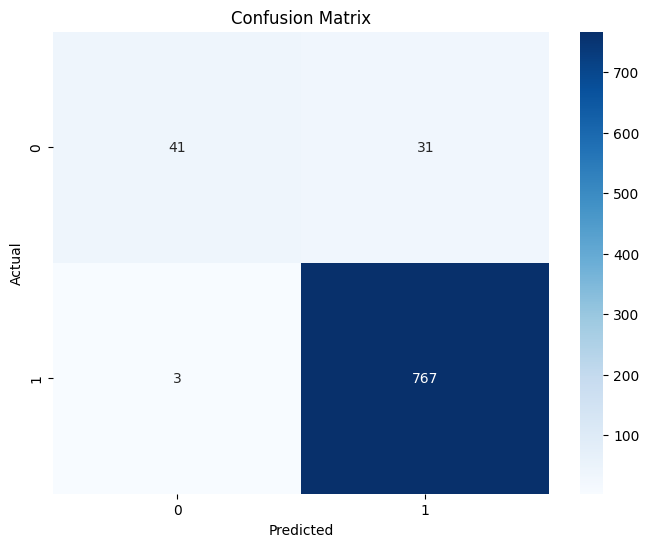

In [19]:
y_pred_continuous = modelo.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score

# Define a threshold to convert continuous predictions to binary classes
threshold = 0.5  # Adjust this threshold based on your specific needs

# Convert continuous predictions to binary classes
y_pred_binary = (y_pred_continuous >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)  # Convert true values to binary as well

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
accuracy = accuracy_score(y_test_binary, y_pred_binary)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
y_test_pred_continuous=modelo.predict(DF_test.iloc[:,5:])

y_test_pred_binary = (y_test_pred_continuous >= threshold).astype(int)
#y_test_binary = (y_test >= threshold).astype(int)  # Convert true values to binary as well

print(y_test_pred_binary)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [21]:
Lab_predicted=[]
for i in y_test_pred_binary:
    if i==1:
        Lab_predicted.append("Susceptible")
    else:
        Lab_predicted.append("Resistant")
my_prediction_df=DF_test.iloc[:,:4]
my_prediction_df["phenotype"] = Lab_predicted

In [22]:
print(my_prediction_df)

       accession        genus   species    phenotype
2805  ERR1417717  Escherichia      coli  Susceptible
2806  ERR1417719  Escherichia      coli  Susceptible
2807  ERR1417722  Escherichia      coli  Susceptible
2808  ERR1417741  Escherichia      coli  Susceptible
2809  ERR1417745  Escherichia      coli  Susceptible
...          ...          ...       ...          ...
3560  SRR3242343   Salmonella  enterica  Susceptible
3561  SRR2082856   Salmonella  enterica  Susceptible
3562  SRR3242362   Salmonella  enterica  Susceptible
3563  SRR1257300   Salmonella  enterica  Susceptible
3564  SRR4280580   Salmonella  enterica  Susceptible

[760 rows x 4 columns]
